<a href="https://colab.research.google.com/github/AceAltair13/facial-expression-recognition/blob/main/ResNet50_FER_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T063811Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D624daf601fac05411894547adf88f230c719919ada83789fd43ea6f2d2eb1dbac792722c13bdd5d4dfb19cd163aa7142ed2ac3e0d9eb9119e9f83e16ec96b78ac4eefae198eca3b077cd0e7823b3733068197a76f5851bfc041d07cfdd8b7280971c5c03f91a91a510990408a55e1ccf5c9d1d007d3de041109c9078b1979ab27e1e62c8e92a36ebdb66568d2b9538844765e6775f47f62132866de24e4a19582cc0931d333a85484d1b9aeb4d7e4af3652a8299711a24dcc8a2b85936d9bf167a6c991e95bc7bffabd7871ed48c0d98e38c7c2956d8d094ff2dd8f7e073cb477bc33042fec85188703e9ad02f896303b1ed9c77694d651dd7e70fb8609144ff'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 63252113 bytes downloaded
Downloaded and uncompressed: fer2013
Data source import complete.


# **ResNet50**

ResNet-50 is CNN architecture that belongs to the ResNet (Residual Networks) family, a series of models designed to address the challenges associated with training deep neural networks.It is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.

### Dataset & Description

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

[Dataset link ](https://www.kaggle.com/msambare/fer2013)

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import keras.backend as K
import tensorflow as tf

# Importing necessary modules from tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation,
)
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge

# Importing necessary callbacks from tensorflow
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    ModelCheckpoint,
    EarlyStopping,
)

from tensorflow.keras.optimizers import Adam

### Data Augmentation and Preprocessing

The following code block is responsible for creating `ImageDataGenerator` instances for training, validation, and testing datasets. These generators handle data augmentation and preprocessing. The training generator includes transformations to increase the size of the training dataset and improve model generalization.

In [3]:
# ImageDataGenerator for training data with data augmentation
training_data_generator = ImageDataGenerator(
    rescale=1.0 / 255, validation_split=0.2, rotation_range=5,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
    horizontal_flip=True, vertical_flip=True, fill_mode="nearest"
)

# ImageDataGenerator for validation data with normalization and validation split
validation_data_generator = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# ImageDataGenerator for testing data with normalization
test_data_generator = ImageDataGenerator(rescale=1.0 / 255)

### Dataset Preparation

The following code block uses the `ImageDataGenerator` instances to load the training, validation, and testing datasets from their respective directories. The images are resized to 48x48 pixels and the labels are one-hot encoded. The datasets are also batched with a size of 64.

In [4]:
# Loading and preprocessing the training dataset
training_dataset = training_data_generator.flow_from_directory(
    directory="../input/fer2013/train",
    target_size=(48, 48),
    class_mode="categorical",
    subset="training",
    batch_size=64,
)

# Loading and preprocessing the validation dataset
validation_dataset = validation_data_generator.flow_from_directory(
    directory="../input/fer2013/train",
    target_size=(48, 48),
    class_mode="categorical",
    subset="validation",
    batch_size=64,
)

# Loading and preprocessing the testing dataset
testing_dataset = test_data_generator.flow_from_directory(
    directory="../input/fer2013/test",
    target_size=(48, 48),
    class_mode="categorical",
    batch_size=64,
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Image Loading and Preprocessing

The following code block loads an image from the test dataset, resizes it to 48x48 pixels, and expands its dimensions to fit the model's input shape. The image is also displayed using matplotlib's `imshow` function.

Image shape: (48, 48, 3)
Expanded image shape: (1, 48, 48, 3)


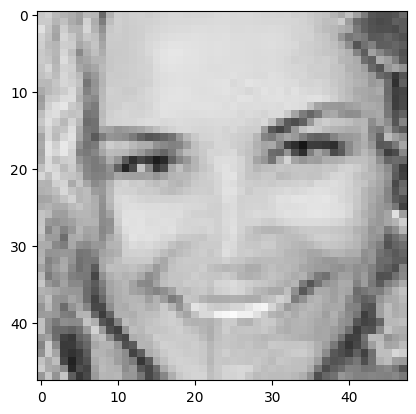

In [5]:
from keras.preprocessing import image
from keras.models import load_model

# Load and resize the image
test_image = image.load_img("../input/fer2013/test/happy/PrivateTest_10077120.jpg", target_size=(48, 48))

# Convert the image to a numpy array
test_image = np.array(test_image)

# Display the image
plt.imshow(test_image)
print(f"Image shape: {test_image.shape}")

# Expand the dimensions of the image
test_image = np.expand_dims(test_image, axis=0)
print(f"Expanded image shape: {test_image.shape}")

# Model Initialization

The following code block initializes a ResNet50 model with pre-trained weights from ImageNet. The top layers of the model, which are typically responsible for classification, are not included. The input shape is set to 48x48 pixels with 3 color channels (RGB).

In [6]:
# Initialize a ResNet50 model with pre-trained weights from ImageNet
base_model = tf.keras.applications.ResNet50(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet"
)

94765736/94765736 [==============================] - 0s 0us/step


### Model Customization and Summary

The following code block first freezes the layers of the base model except for the last four. Then, a new model is built on top of the base model. This new model includes dropout, flatten, batch normalization, dense, and activation layers. Finally, the summary of the model is displayed.

In [7]:
# Freezing all layers of the base model except the last four
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Building a new model on top of the base model
model = Sequential([
    base_model,
    Dropout(0.5),
    Flatten(),

    BatchNormalization(),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dense(7, activation='softmax')
])

# Displaying the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

### Model Visualization

The following code block visualizes the architecture of the model using `plot_model` from Keras. The resulting plot is saved as 'convnet.png' and then displayed using IPython's `Image`.

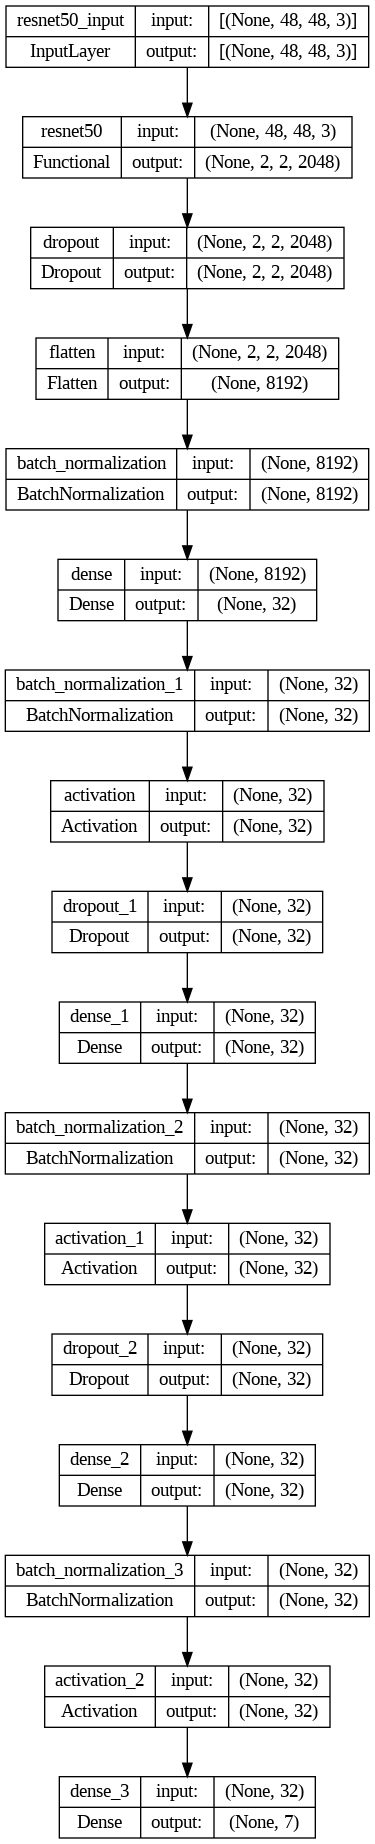

In [8]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Plotting the model architecture and saving it to a file
plot_model(model, to_file='resnet_model.png', show_shapes=True, show_layer_names=True)

# Displaying the saved image
Image(filename='resnet_model.png')

### F1 Score Calculation

The following function calculates the F1 score, which is a measure of a model's accuracy. It does this by computing the harmonic mean of precision and recall. The function uses Keras backend functions to ensure compatibility with tensors.

In [9]:
def f1_score(actual, predicted):
    # Compute the number of true positives
    true_positives = K.sum(K.round(K.clip(actual * predicted, 0, 1)))
    # Compute the number of possible positives
    possible_positives = K.sum(K.round(K.clip(actual, 0, 1)))
    # Compute the number of predicted positives
    predicted_positives = K.sum(K.round(K.clip(predicted, 0, 1)))
    # Compute precision
    precision = true_positives / (predicted_positives + K.epsilon())
    # Compute recall
    recall = true_positives / (possible_positives + K.epsilon())
    # Compute F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

### Metrics Selection

The following code block defines a list of metrics that will be used to evaluate the model's performance during training. These metrics include binary accuracy, precision, recall, AUC (Area Under the ROC Curve), and the custom F1 score function defined earlier.

In [10]:
# Define the metrics for model evaluation
evaluation_metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

### Callbacks Configuration

The following code block sets up three callbacks for the model training process:

1. `ReduceLROnPlateau`: This reduces the learning rate when a metric has stopped improving, which can lead to better model performance.
2. `ModelCheckpoint`: This saves the model after every epoch.
3. `EarlyStopping`: This stops the training process when a metric has stopped improving, which can save time and resources.

In [11]:
# Set up a learning rate reduction on plateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=20,
    verbose=1,
    factor=0.50,
    min_lr=1e-10
)

# Set up a model checkpoint to save the model after every epoch
model_checkpoint = ModelCheckpoint('model.h5')

# Set up early stopping to stop training when a metric has stopped improving
early_stopping = EarlyStopping(verbose=1, patience=20)

# Model Compilation and Training

The following code block first compiles the model using the Adam optimizer, categorical crossentropy as the loss function, and the previously defined metrics for evaluation. Then, the model is trained for 60 epochs using the training and validation datasets. The learning rate reduction, model checkpoint, and early stopping callbacks are also used during training.

In [13]:
# Compile the model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=evaluation_metrics
)

# Train the model
training_history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=60,
    verbose=1,
    callbacks=[learning_rate_reduction, model_checkpoint, early_stopping]
)

Epoch 1/60
359/359 [==============================] - ETA: 0s - loss: 1.9215 - accuracy: 0.8552 - precision: 0.1992 - recall: 0.0045 - auc: 0.6020 - f1_score: 0.0087

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 58s 146ms/step - loss: 1.9215 - accuracy: 0.8552 - precision: 0.1992 - recall: 0.0045 - auc: 0.6020 - f1_score: 0.0087 - val_loss: 1.8318 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6385 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/60
359/359 [==============================] - 50s 140ms/step - loss: 1.8370 - accuracy: 0.8569 - precision: 0.2740 - recall: 8.7078e-04 - auc: 0.6347 - f1_score: 0.0017 - val_loss: 1.8205 - val_accuracy: 0.8571 - val_precision: 0.4000 - val_recall: 3.4837e-04 - val_auc: 0.6379 - val_f1_score: 6.7858e-04 - lr: 0.0010
Epoch 3/60
359/359 [==============================] - 50s 139ms/step - loss: 1.8255 - accuracy: 0.8571 - precision: 0.2143 - recall: 1.3062e-04 - auc: 0.6379 - f1_score: 2.5712e-04 - val_loss: 1.8213 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6417 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/60
359/359 [=====

# Plotting Training and Validation Metrics

The following function, `plot_training_validation_metrics`, takes the history of accuracy, loss, AUC, precision, and F1 score for both training and validation. It then plots these metrics over the epochs to visualize the model's performance during training.

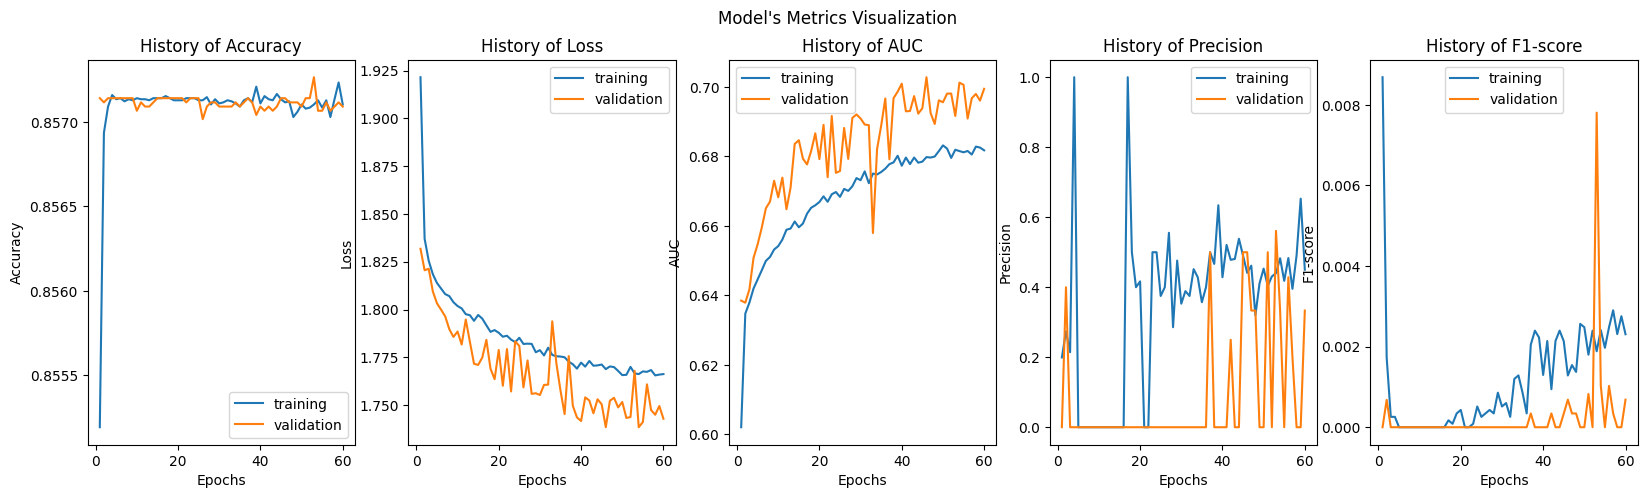

In [14]:
# Define a function to plot training and validation metrics
def plot_training_and_validation_metrics(training_accuracy, validation_accuracy, training_loss, validation_loss, training_auc, validation_auc, training_precision, validation_precision, training_f1, validation_f1):
    # Create a figure with 5 subplots for 5 metrics
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 5))
    fig.suptitle("Model's Metrics Visualization")

    # Define a list of metrics to plot
    metrics = [
        (training_accuracy, validation_accuracy, 'Accuracy', ax1),
        (training_loss, validation_loss, 'Loss', ax2),
        (training_auc, validation_auc, 'AUC', ax3),
        (training_precision, validation_precision, 'Precision', ax4),
        (training_f1, validation_f1, 'F1-score', ax5),
    ]

    # Loop through the metrics list and plot each metric
    for training, validation, metric_name, ax in metrics:
        ax.plot(range(1, len(training) + 1), training)
        ax.plot(range(1, len(validation) + 1), validation)
        ax.set_title(f'History of {metric_name}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric_name)
        ax.legend(['training', 'validation'])

    # Display the plots
    plt.show()

# Call the function with the history of metrics from the model training process
plot_training_and_validation_metrics(
    training_history.history['accuracy'], training_history.history['val_accuracy'],
    training_history.history['loss'], training_history.history['val_loss'],
    training_history.history['auc'], training_history.history['val_auc'],
    training_history.history['precision'], training_history.history['val_precision'],
    training_history.history['f1_score'], training_history.history['val_f1_score']
)